In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns # 引入 seaborn 来使用更专业的调色板
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

# 设置字体为Arial
plt.rcParams['font.family'] = 'Arial'

# 读取可行性分析结果数据
data_path = Path("../result/island_viability_summary_electric.csv")
df = pd.read_csv(data_path)

# 显示数据概况
print(f"数据形状: {df.shape}")
print(f"情景列表: {df['scenario'].unique()}")
print(f"Viability gap统计:")
print(df['viability_gap'].describe())



数据形状: (10980, 16)
情景列表: ['output_0' 'output_2020' 'output_2050' 'output_future_2030'
 'output_future_2040' 'output_future_2050']
Viability gap统计:
count    10980.000000
mean        -0.425257
std          0.739480
min         -4.148942
25%         -1.006200
50%          0.043717
75%          0.082420
max          0.954005
Name: viability_gap, dtype: float64


In [6]:
# --- 数据处理函数 ---
def assign_ipcc_region(lat, lon, ipcc_regions_gdf):
    """将岛屿坐标分配到IPCC区域"""
    point = Point(lon, lat)
    possible_matches_index = list(ipcc_regions_gdf.sindex.intersection(point.bounds))
    possible_matches = ipcc_regions_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.contains(point)]
    if not precise_matches.empty:
        return precise_matches.iloc[0]['Acronym']
    return 'Unknown'

def calculate_position_change(df_base, df_compare):
    """计算两个情景之间的位置变化 - 修正版，包含IPCC区域信息"""
    # 修正：合并时包含ipcc_region信息
    merged = pd.merge(df_base[['island_id', 'tariff_breakeven', 'ipcc_region']],
                      df_compare[['island_id', 'tariff_breakeven']],
                      on='island_id', suffixes=('_base', '_compare'))
    merged['position_change'] = abs(merged['tariff_breakeven_compare'] - merged['tariff_breakeven_base'])
    # 重命名ipcc_region列以保持一致性
    merged = merged.rename(columns={'ipcc_region': 'ipcc_region_base'})
    return merged

def create_raincloud_plot_with_shapes(data_ideal, data_2020, data_2050, 
                                      class_ideal, class_2020, class_2050, 
                                      ax, region_name, color_ideal, color_2020, color_2050):
    """
    创建改进的云雨图：每个scenario占据上中下三个区域，每个区域内从下到上是点-箱线图-半小提琴图
    新增功能：使用不同形状表示不同的分类(quadrant)
    x轴显示tariff_breakeven的原始数值，而不是变化量
    
    Args:
        data_ideal: Ideal情景的tariff_breakeven数值
        data_2020: 2020情景的tariff_breakeven数值  
        data_2050: 2050情景的tariff_breakeven数值
        class_ideal: Ideal情景的分类数据(quadrant)
        class_2020: 2020情景的分类数据(quadrant)
        class_2050: 2050情景的分类数据(quadrant)
        ax: matplotlib轴对象
        region_name: IPCC区域名称
        color_ideal, color_2020, color_2050: 三个情景的颜色
    """
    # 定义分类对应的形状映射
    shape_mapping = {
        'High Affordable\\nLow Cost': 'o',      # 圆形 - 最理想状态
        'High Affordable\\nHigh Cost': 's',     # 正方形 - 高可负担但成本高
        'Low Affordable\\nLow Cost': '^',       # 三角形 - 低可负担但成本低  
        'Low Affordable\\nHigh Cost': 'D'       # 菱形 - 最不理想状态
    }
    
    # 计算数据范围
    all_data = np.concatenate([data_ideal, data_2020, data_2050])
    if len(all_data) == 0:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
        return
        
    x_min, x_max = all_data.min(), all_data.max()
    x_range = x_max - x_min if x_max != x_min else 1
    x_padding = x_range * 0.1  # x轴边距比例
    
    # 设置y轴位置（分为上中下三个区域）
    # Ideal scenario（上部分：0.68-1.0）
    y_ideal_points = 0.72    # Ideal散点位置
    y_ideal_box = 0.78       # Ideal箱线图位置
    y_ideal_violin = 0.84    # Ideal小提琴图基准线位置
    
    # 2020 scenario（中部分：0.34-0.66）
    y_2020_points = 0.38     # 2020散点位置
    y_2020_box = 0.44        # 2020箱线图位置
    y_2020_violin = 0.50     # 2020小提琴图基准线位置
    
    # 2050 scenario（下部分：0.0-0.32）
    y_2050_points = 0.04     # 2050散点位置
    y_2050_box = 0.10        # 2050箱线图位置
    y_2050_violin = 0.16     # 2050小提琴图基准线位置
    
    np.random.seed(42)  # 确保结果可重现
    
    def plot_classified_scatter(data, classifications, y_base, color, jitter_std=0.015, point_size=35):
        """绘制带分类形状的散点图"""
        if len(data) == 0:
            return
            
        y_jitter = np.random.normal(y_base, jitter_std, len(data))  # 垂直抖动
        
        # 按分类分组绘制不同形状
        for class_name, marker in shape_mapping.items():
            # 找到属于该分类的点
            class_mask = classifications == class_name
            if np.any(class_mask):
                class_data = data[class_mask]
                class_y = y_jitter[class_mask]
                
                # 绘制该分类的散点
                ax.scatter(class_data, class_y, 
                          marker=marker,                    # 使用分类对应的形状
                          color=color,                      # 保持情景颜色
                          alpha=0.7,                        # 透明度
                          s=point_size,                     # 点大小
                          edgecolors='white',               # 白色边框
                          linewidth=0.5,                    # 边框宽度
                          zorder=3)                         # 层级
    
    # === Ideal Scenario（上部分）===
    if len(data_ideal) > 0:
        # 1. 散点图（最下层）- 使用形状区分分类
        plot_classified_scatter(data_ideal, class_ideal, y_ideal_points, color_ideal, point_size=35)
        
        # 2. 箱线图（中间层）
        q25, q50, q75 = np.percentile(data_ideal, [25, 50, 75])  # 计算四分位数
        iqr = q75 - q25  # 四分位距
        whisker_low = max(data_ideal.min(), q25 - 1.5 * iqr)  # 下须限制
        whisker_high = min(data_ideal.max(), q75 + 1.5 * iqr)  # 上须限制
        
        # 箱体
        box_height = 0.025  # 箱体高度
        ax.add_patch(plt.Rectangle((q25, y_ideal_box - box_height/2), q75 - q25, box_height,
                                  facecolor=color_ideal, alpha=0.6, zorder=2))  # 箱体透明度
        # 中位数线
        ax.plot([q50, q50], [y_ideal_box - box_height/2, y_ideal_box + box_height/2], 
               color='black', linewidth=2, zorder=4)  # 中位数线宽度
        # 须线
        ax.plot([whisker_low, q25], [y_ideal_box, y_ideal_box], color='black', linewidth=1, zorder=2)  # 须线宽度
        ax.plot([q75, whisker_high], [y_ideal_box, y_ideal_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_ideal_box - box_height/4, y_ideal_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_ideal_box - box_height/4, y_ideal_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        
        # 3. 半小提琴图（上层，只显示向上的部分）
        if len(data_ideal) > 3:
            try:
                kde_ideal = stats.gaussian_kde(data_ideal)  # 核密度估计
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)  # 密度估计x轴范围
                density_ideal = kde_ideal(x_kde)
                # 归一化密度并缩放
                density_ideal_scaled = density_ideal / density_ideal.max() * 0.10  # 小提琴图高度缩放
                
                # 只向上填充（半小提琴）
                ax.fill_between(x_kde, y_ideal_violin, y_ideal_violin + density_ideal_scaled, 
                              alpha=0.4, color=color_ideal, zorder=1)  # 小提琴图透明度
                # 底边线
                ax.plot(x_kde, [y_ideal_violin] * len(x_kde), color=color_ideal, linewidth=1, alpha=0.8, zorder=1)
            except:
                pass
    
    # === 2020 Scenario（中部分）===
    if len(data_2020) > 0:
        # 1. 散点图（最下层）- 使用形状区分分类
        plot_classified_scatter(data_2020, class_2020, y_2020_points, color_2020, point_size=35)
        
        # 2. 箱线图（中间层）
        q25, q50, q75 = np.percentile(data_2020, [25, 50, 75])
        iqr = q75 - q25
        whisker_low = max(data_2020.min(), q25 - 1.5 * iqr)
        whisker_high = min(data_2020.max(), q75 + 1.5 * iqr)
        
        # 箱体
        box_height = 0.025
        ax.add_patch(plt.Rectangle((q25, y_2020_box - box_height/2), q75 - q25, box_height,
                                  facecolor=color_2020, alpha=0.6, zorder=2))
        # 中位数线
        ax.plot([q50, q50], [y_2020_box - box_height/2, y_2020_box + box_height/2], 
               color='black', linewidth=2, zorder=4)
        # 须线
        ax.plot([whisker_low, q25], [y_2020_box, y_2020_box], color='black', linewidth=1, zorder=2)
        ax.plot([q75, whisker_high], [y_2020_box, y_2020_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_2020_box - box_height/4, y_2020_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_2020_box - box_height/4, y_2020_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        
        # 3. 半小提琴图（上层，只显示向上的部分）
        if len(data_2020) > 3:
            try:
                kde_2020 = stats.gaussian_kde(data_2020)
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)
                density_2020 = kde_2020(x_kde)
                # 归一化密度并缩放
                density_2020_scaled = density_2020 / density_2020.max() * 0.10
                
                # 只向上填充（半小提琴）
                ax.fill_between(x_kde, y_2020_violin, y_2020_violin + density_2020_scaled, 
                              alpha=0.4, color=color_2020, zorder=1)
                # 底边线
                ax.plot(x_kde, [y_2020_violin] * len(x_kde), color=color_2020, linewidth=1, alpha=0.8, zorder=1)
            except:
                pass
    
    # === 2050 Scenario（下部分）===
    if len(data_2050) > 0:
        # 1. 散点图（最下层）- 使用形状区分分类
        plot_classified_scatter(data_2050, class_2050, y_2050_points, color_2050, point_size=35)
        
        # 2. 箱线图（中间层）
        q25, q50, q75 = np.percentile(data_2050, [25, 50, 75])
        iqr = q75 - q25
        whisker_low = max(data_2050.min(), q25 - 1.5 * iqr)
        whisker_high = min(data_2050.max(), q75 + 1.5 * iqr)
        
        # 箱体
        box_height = 0.025
        ax.add_patch(plt.Rectangle((q25, y_2050_box - box_height/2), q75 - q25, box_height,
                                  facecolor=color_2050, alpha=0.9, zorder=2))
        # 中位数线
        ax.plot([q50, q50], [y_2050_box - box_height/2, y_2050_box + box_height/2], 
               color='black', linewidth=2, zorder=4)
        # 须线
        ax.plot([whisker_low, q25], [y_2050_box, y_2050_box], color='black', linewidth=1, zorder=2)
        ax.plot([q75, whisker_high], [y_2050_box, y_2050_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_2050_box - box_height/4, y_2050_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_2050_box - box_height/4, y_2050_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        
        # 3. 半小提琴图（上层，只显示向上的部分）
        if len(data_2050) > 3:
            try:
                kde_2050 = stats.gaussian_kde(data_2050)
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)
                density_2050 = kde_2050(x_kde)
                # 归一化密度并缩放
                density_2050_scaled = density_2050 / density_2050.max() * 0.10
                
                # 只向上填充（半小提琴）
                ax.fill_between(x_kde, y_2050_violin, y_2050_violin + density_2050_scaled, 
                              alpha=0.9, color=color_2050, zorder=1)
                # 底边线
                ax.plot(x_kde, [y_2050_violin] * len(x_kde), color=color_2050, linewidth=1, alpha=0.8, zorder=1)
            except:
                pass
    
    # 4. 设置轴和标签
    ax.set_ylim(-0.02, 1.02)  # y轴范围
    
    # 设置y轴标签，标识三个scenario区域
    ax.set_yticks([0.10, 0.44, 0.78])  # 在每个scenario的中间位置设置刻度
    ax.set_yticklabels(['Climate Stress', 'Baseline', 'Ideal'], fontsize=16, fontweight='bold')  # y轴标签字体大小和粗细
    
    # 添加区域标题
    ax.set_title(f'{region_name}', fontsize=18, pad=10, fontweight='bold')  # 区域标题字体大小和粗细
    
    ax.grid(False)  # 关闭网格
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['top'].set_visible(False)    # 隐藏顶部边框
    
    # 设置x轴范围
    ax.set_xlim(x_min - x_padding, x_max + x_padding)

def classify_islands_by_quadrant(df_scenario, median_breakeven, median_affordable):
    """
    根据tariff_breakeven和tariff_affordable的中位数将岛屿分类到四个象限

    Args:
        df_scenario: 特定情景的数据
        median_breakeven: tariff_breakeven的中位数阈值
        median_affordable: tariff_affordable的中位数阈值

    Returns:
        分类标签数组
    """
    classifications = []
    for _, row in df_scenario.iterrows():
        breakeven = row['tariff_breakeven']
        affordable = row['tariff_affordable']

        # 根据与中位数的比较进行分类
        if affordable >= median_affordable and breakeven <= median_breakeven:
            # 高可负担性，低成本 - 最理想状态
            classifications.append('High Affordable\\nLow Cost')
        elif affordable >= median_affordable and breakeven > median_breakeven:
            # 高可负担性，高成本
            classifications.append('High Affordable\\nHigh Cost')
        elif affordable < median_affordable and breakeven <= median_breakeven:
            # 低可负担性，低成本
            classifications.append('Low Affordable\\nLow Cost')
        else:
            # 低可负担性，高成本 - 最不理想状态
            classifications.append('Low Affordable\\nHigh Cost')

    return np.array(classifications)

# --- 1. 数据加载和预处理 ---
try:
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")
    ipcc_regions.sindex  # 创建空间索引
    df['ipcc_region'] = df.apply(lambda row: assign_ipcc_region(row['lat'], row['lon'], ipcc_regions), axis=1)
    print(f"成功分配IPCC区域，共有 {df['ipcc_region'].nunique()} 个区域")
except Exception as e:
    print(f"无法加载 geojson 文件或处理数据: {e}.")
    df['ipcc_region'] = 'Unknown'

# 筛选出有效区域（岛屿数量足够的区域）
MIN_ISLANDS_PER_REGION = 10  # 每个区域最少岛屿数量阈值
region_counts = df['ipcc_region'].value_counts()
valid_regions = region_counts[region_counts > MIN_ISLANDS_PER_REGION].index.tolist()
print(f"有效区域 (岛屿数量>{MIN_ISLANDS_PER_REGION}): {len(valid_regions)} 个")
print(f"有效区域列表: {valid_regions}")

# 主程序：创建多子图云雨图（带分类形状）
if __name__ == '__main__':
    print("开始创建三情景云雨图（带分类形状）...")

    # 检查ipcc_region列是否存在
    if 'ipcc_region' not in df.columns:
        print("错误：ipcc_region列不存在！")
    else:
        print(f"ipcc_region列存在，共有 {df['ipcc_region'].nunique()} 个区域")

    # 筛选三个情景的数据（基于有显著变化的岛屿）
    df_base_ideal = df[(df['scenario'] == 'output_0') & (df['ipcc_region'].isin(valid_regions))].copy()
    df_compare_2020 = df[(df['scenario'] == 'output_2020') & (df['ipcc_region'].isin(valid_regions))].copy()
    df_compare_2050 = df[(df['scenario'] == 'output_2050') & (df['ipcc_region'].isin(valid_regions))].copy()

    print(f"Ideal数据: {len(df_base_ideal)} 个岛屿")
    print(f"2020数据: {len(df_compare_2020)} 个岛屿")
    print(f"2050数据: {len(df_compare_2050)} 个岛屿")

    # 计算全局中位数（基于Ideal情景）用于分类
    median_breakeven = df_base_ideal['tariff_breakeven'].median()  # 全局breakeven中位数
    median_affordable = df_base_ideal['tariff_affordable'].median()  # 全局affordable中位数
    print(f"全局中位数: breakeven = {median_breakeven:.3f}, affordable = {median_affordable:.3f}")

    # 计算变化以确定哪些岛屿有显著变化（仍然用于筛选）
    change_2020 = calculate_position_change(df_base_ideal, df_compare_2020)
    change_2050 = calculate_position_change(df_base_ideal, df_compare_2050)

    # 筛选有显著变化的区域（基于2020和2050的变化）
    significant_2020 = change_2020[change_2020['position_change'] > 0.1]  # 显著性阈值
    significant_2050 = change_2050[change_2050['position_change'] > 0.1]

    print(f"2020显著变化岛屿数: {len(significant_2020)}")
    print(f"2050显著变化岛屿数: {len(significant_2050)}")

    # 获取在至少一个scenario中有显著变化的区域
    regions_2020 = set(significant_2020['ipcc_region_base'].unique()) if len(significant_2020) > 0 else set()
    regions_2050 = set(significant_2050['ipcc_region_base'].unique()) if len(significant_2050) > 0 else set()
    common_regions = list(regions_2020.union(regions_2050))  # 使用并集，显示所有有变化的区域

    print(f"发现在至少一个scenario中有显著变化的区域: {len(common_regions)} 个")
    print(f"区域列表: {common_regions}")

    if len(common_regions) == 0:
        print("没有发现有显著变化的区域")
    else:
        print("开始生成三情景云雨图（带分类形状）...")
        # 计算子图布局
        n_regions = len(common_regions)
        n_cols = min(4, n_regions)  # 最多4列
        n_rows = (n_regions + n_cols - 1) // n_cols  # 向上取整计算行数

        # 创建图形 - 提高DPI设置
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 4*n_rows), dpi=450)  # 提高DPI到450
        if n_regions == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()

        # 定义三个情景的颜色
        color_ideal = '#4C72B0'   # Ideal情景颜色 - 蓝色
        color_2020 = '#DD8452'    # 2020情景颜色 - 橙色
        color_2050 = '#C44E52'    # 2050情景颜色 - 红色

        # 为每个区域创建子图
        for i, region in enumerate(common_regions):
            ax = axes[i]

            # 获取该区域在三个scenario下的数据
            region_df_ideal = df_base_ideal[df_base_ideal['ipcc_region'] == region]
            region_df_2020 = df_compare_2020[df_compare_2020['ipcc_region'] == region]
            region_df_2050 = df_compare_2050[df_compare_2050['ipcc_region'] == region]

            # 获取tariff_breakeven数值
            region_data_ideal = region_df_ideal['tariff_breakeven'].values
            region_data_2020 = region_df_2020['tariff_breakeven'].values
            region_data_2050 = region_df_2050['tariff_breakeven'].values

            # 对每个情景的岛屿进行分类
            class_ideal = classify_islands_by_quadrant(region_df_ideal, median_breakeven, median_affordable)
            class_2020 = classify_islands_by_quadrant(region_df_2020, median_breakeven, median_affordable)
            class_2050 = classify_islands_by_quadrant(region_df_2050, median_breakeven, median_affordable)

            print(f"区域 {region}: Ideal数据 {len(region_data_ideal)} 个, 2020数据 {len(region_data_2020)} 个, 2050数据 {len(region_data_2050)} 个")

            # 绘制带分类形状的云雨图
            create_raincloud_plot_with_shapes(
                region_data_ideal, region_data_2020, region_data_2050,
                class_ideal, class_2020, class_2050,
                ax, region, color_ideal, color_2020, color_2050
            )

        # 隐藏多余的子图
        for i in range(n_regions, len(axes)):
            axes[i].set_visible(False)

        # 为所有子图添加统一的x轴标签
        for i in range(n_regions):
            if i >= (n_rows-1) * n_cols:  # 最后一行的子图
                axes[i].set_xlabel('Cost Recovery Electricity Price (USD/kWh)', fontsize=20)  # x轴标签字体大小

        # Nature风格图例：简洁，无标题，只保留必要信息
        from matplotlib.lines import Line2D
        
        # 形状分类图例 - 使用灰色以不干扰数据颜色，增大图例标记尺寸
        shape_legend = [
            Line2D([0], [0], marker='o', color='gray', linestyle='None', 
                  markersize=18, label='High affordable, low cost'),  # 圆形 - 最理想，增大标记尺寸
            Line2D([0], [0], marker='s', color='gray', linestyle='None',
                  markersize=18, label='High affordable, high cost'),  # 正方形，增大标记尺寸
            Line2D([0], [0], marker='^', color='gray', linestyle='None',
                  markersize=18, label='Low affordable, low cost'),   # 三角形，增大标记尺寸
            Line2D([0], [0], marker='D', color='gray', linestyle='None',
                  markersize=18, label='Low affordable, high cost'),  # 菱形 - 最不理想，增大标记尺寸
        ]

        # 添加简洁的图例
        fig.legend(handles=shape_legend, loc='upper center', 
                  bbox_to_anchor=(0.5, 0.95), ncol=4, 
                  fontsize=18, frameon=False)  # Nature风格：无边框

        plt.tight_layout()  # 自动调整子图间距
        plt.subplots_adjust(top=0.90)  # 调整顶部边距为图例留出空间
        plt.show()

        # 打印统计信息
        print(f"\n=== 三情景区域tariff_breakeven统计 ===")
        for region in common_regions:
            data_ideal = df_base_ideal[df_base_ideal['ipcc_region'] == region]['tariff_breakeven'].values
            data_2020 = df_compare_2020[df_compare_2020['ipcc_region'] == region]['tariff_breakeven'].values
            data_2050 = df_compare_2050[df_compare_2050['ipcc_region'] == region]['tariff_breakeven'].values

            print(f"\n{region}:")
            if len(data_ideal) > 0:
                print(f"  Ideal: {len(data_ideal)} islands, median = {np.median(data_ideal):.3f}, mean = {np.mean(data_ideal):.3f}")
            if len(data_2020) > 0:
                print(f"  2020: {len(data_2020)} islands, median = {np.median(data_2020):.3f}, mean = {np.mean(data_2020):.3f}")
            if len(data_2050) > 0:
                print(f"  2050: {len(data_2050)} islands, median = {np.median(data_2050):.3f}, mean = {np.mean(data_2050):.3f}")

成功分配IPCC区域，共有 43 个区域
有效区域 (岛屿数量>10): 39 个
有效区域列表: ['SEA', 'EAS', 'NEU', 'MED', 'EPO', 'SAS', 'SPO', 'CAR', 'ENA', 'WAF', 'NAU', 'NAO', 'SWS', 'NWN', 'WNA', 'ARP', 'SCA', 'NPO', 'NZ', 'BOB', 'SSA', 'RFE', 'MDG', 'NCA', 'SAH', 'SAU', 'WCA', 'WCE', 'SEAF', 'NEN', 'ESAF', 'EIO', 'NES', 'EAU', 'SIO', 'GIC', 'CAF', 'EAO', 'NSA']
开始创建三情景云雨图（带分类形状）...
ipcc_region列存在，共有 43 个区域
Ideal数据: 1826 个岛屿
2020数据: 1826 个岛屿
2050数据: 1826 个岛屿
全局中位数: breakeven = 0.197, affordable = 0.146
2020显著变化岛屿数: 54
2050显著变化岛屿数: 66
发现在至少一个scenario中有显著变化的区域: 13 个
区域列表: ['NPO', 'RFE', 'WNA', 'ENA', 'BOB', 'NWN', 'SWS', 'SAU', 'SSA', 'NAU', 'EAS', 'NEU', 'NZ']
开始生成三情景云雨图（带分类形状）...
区域 NPO: Ideal数据 13 个, 2020数据 13 个, 2050数据 13 个
区域 RFE: Ideal数据 10 个, 2020数据 10 个, 2050数据 10 个
区域 WNA: Ideal数据 18 个, 2020数据 18 个, 2050数据 18 个
区域 ENA: Ideal数据 45 个, 2020数据 45 个, 2050数据 45 个
区域 BOB: Ideal数据 11 个, 2020数据 11 个, 2050数据 11 个
区域 NWN: Ideal数据 25 个, 2020数据 25 个, 2050数据 25 个
区域 SWS: Ideal数据 26 个, 2020数据 26 个, 2050数据 26 个
区域 SAU: Ideal数据 8 个, 2


=== 三情景区域tariff_breakeven统计 ===

NPO:
  Ideal: 13 islands, median = 0.233, mean = 0.321
  2020: 13 islands, median = 0.236, mean = 0.379
  2050: 13 islands, median = 0.256, mean = 0.367

RFE:
  Ideal: 10 islands, median = 0.390, mean = 0.477
  2020: 10 islands, median = 0.502, mean = 0.624
  2050: 10 islands, median = 0.482, mean = 0.549

WNA:
  Ideal: 18 islands, median = 0.441, mean = 0.478
  2020: 18 islands, median = 0.529, mean = 0.585
  2050: 18 islands, median = 0.435, mean = 0.489

ENA:
  Ideal: 45 islands, median = 0.428, mean = 0.425
  2020: 45 islands, median = 0.436, mean = 0.436
  2050: 45 islands, median = 0.431, mean = 0.445

BOB:
  Ideal: 11 islands, median = 0.200, mean = 0.199
  2020: 11 islands, median = 0.201, mean = 0.235
  2050: 11 islands, median = 0.201, mean = 0.242

NWN:
  Ideal: 25 islands, median = 0.611, mean = 0.673
  2020: 25 islands, median = 0.708, mean = 0.756
  2050: 25 islands, median = 0.659, mean = 0.741

SWS:
  Ideal: 26 islands, median = 0.204, 

ipcc_region列已存在，开始分析...

--- 正在对比三个情景，但只显示在 'output_0' 和 'output_2020' 之间有显著变化的岛屿 ---
发现 171 个有显著变化的岛屿（在 output_0 和 output_2020 之间）。


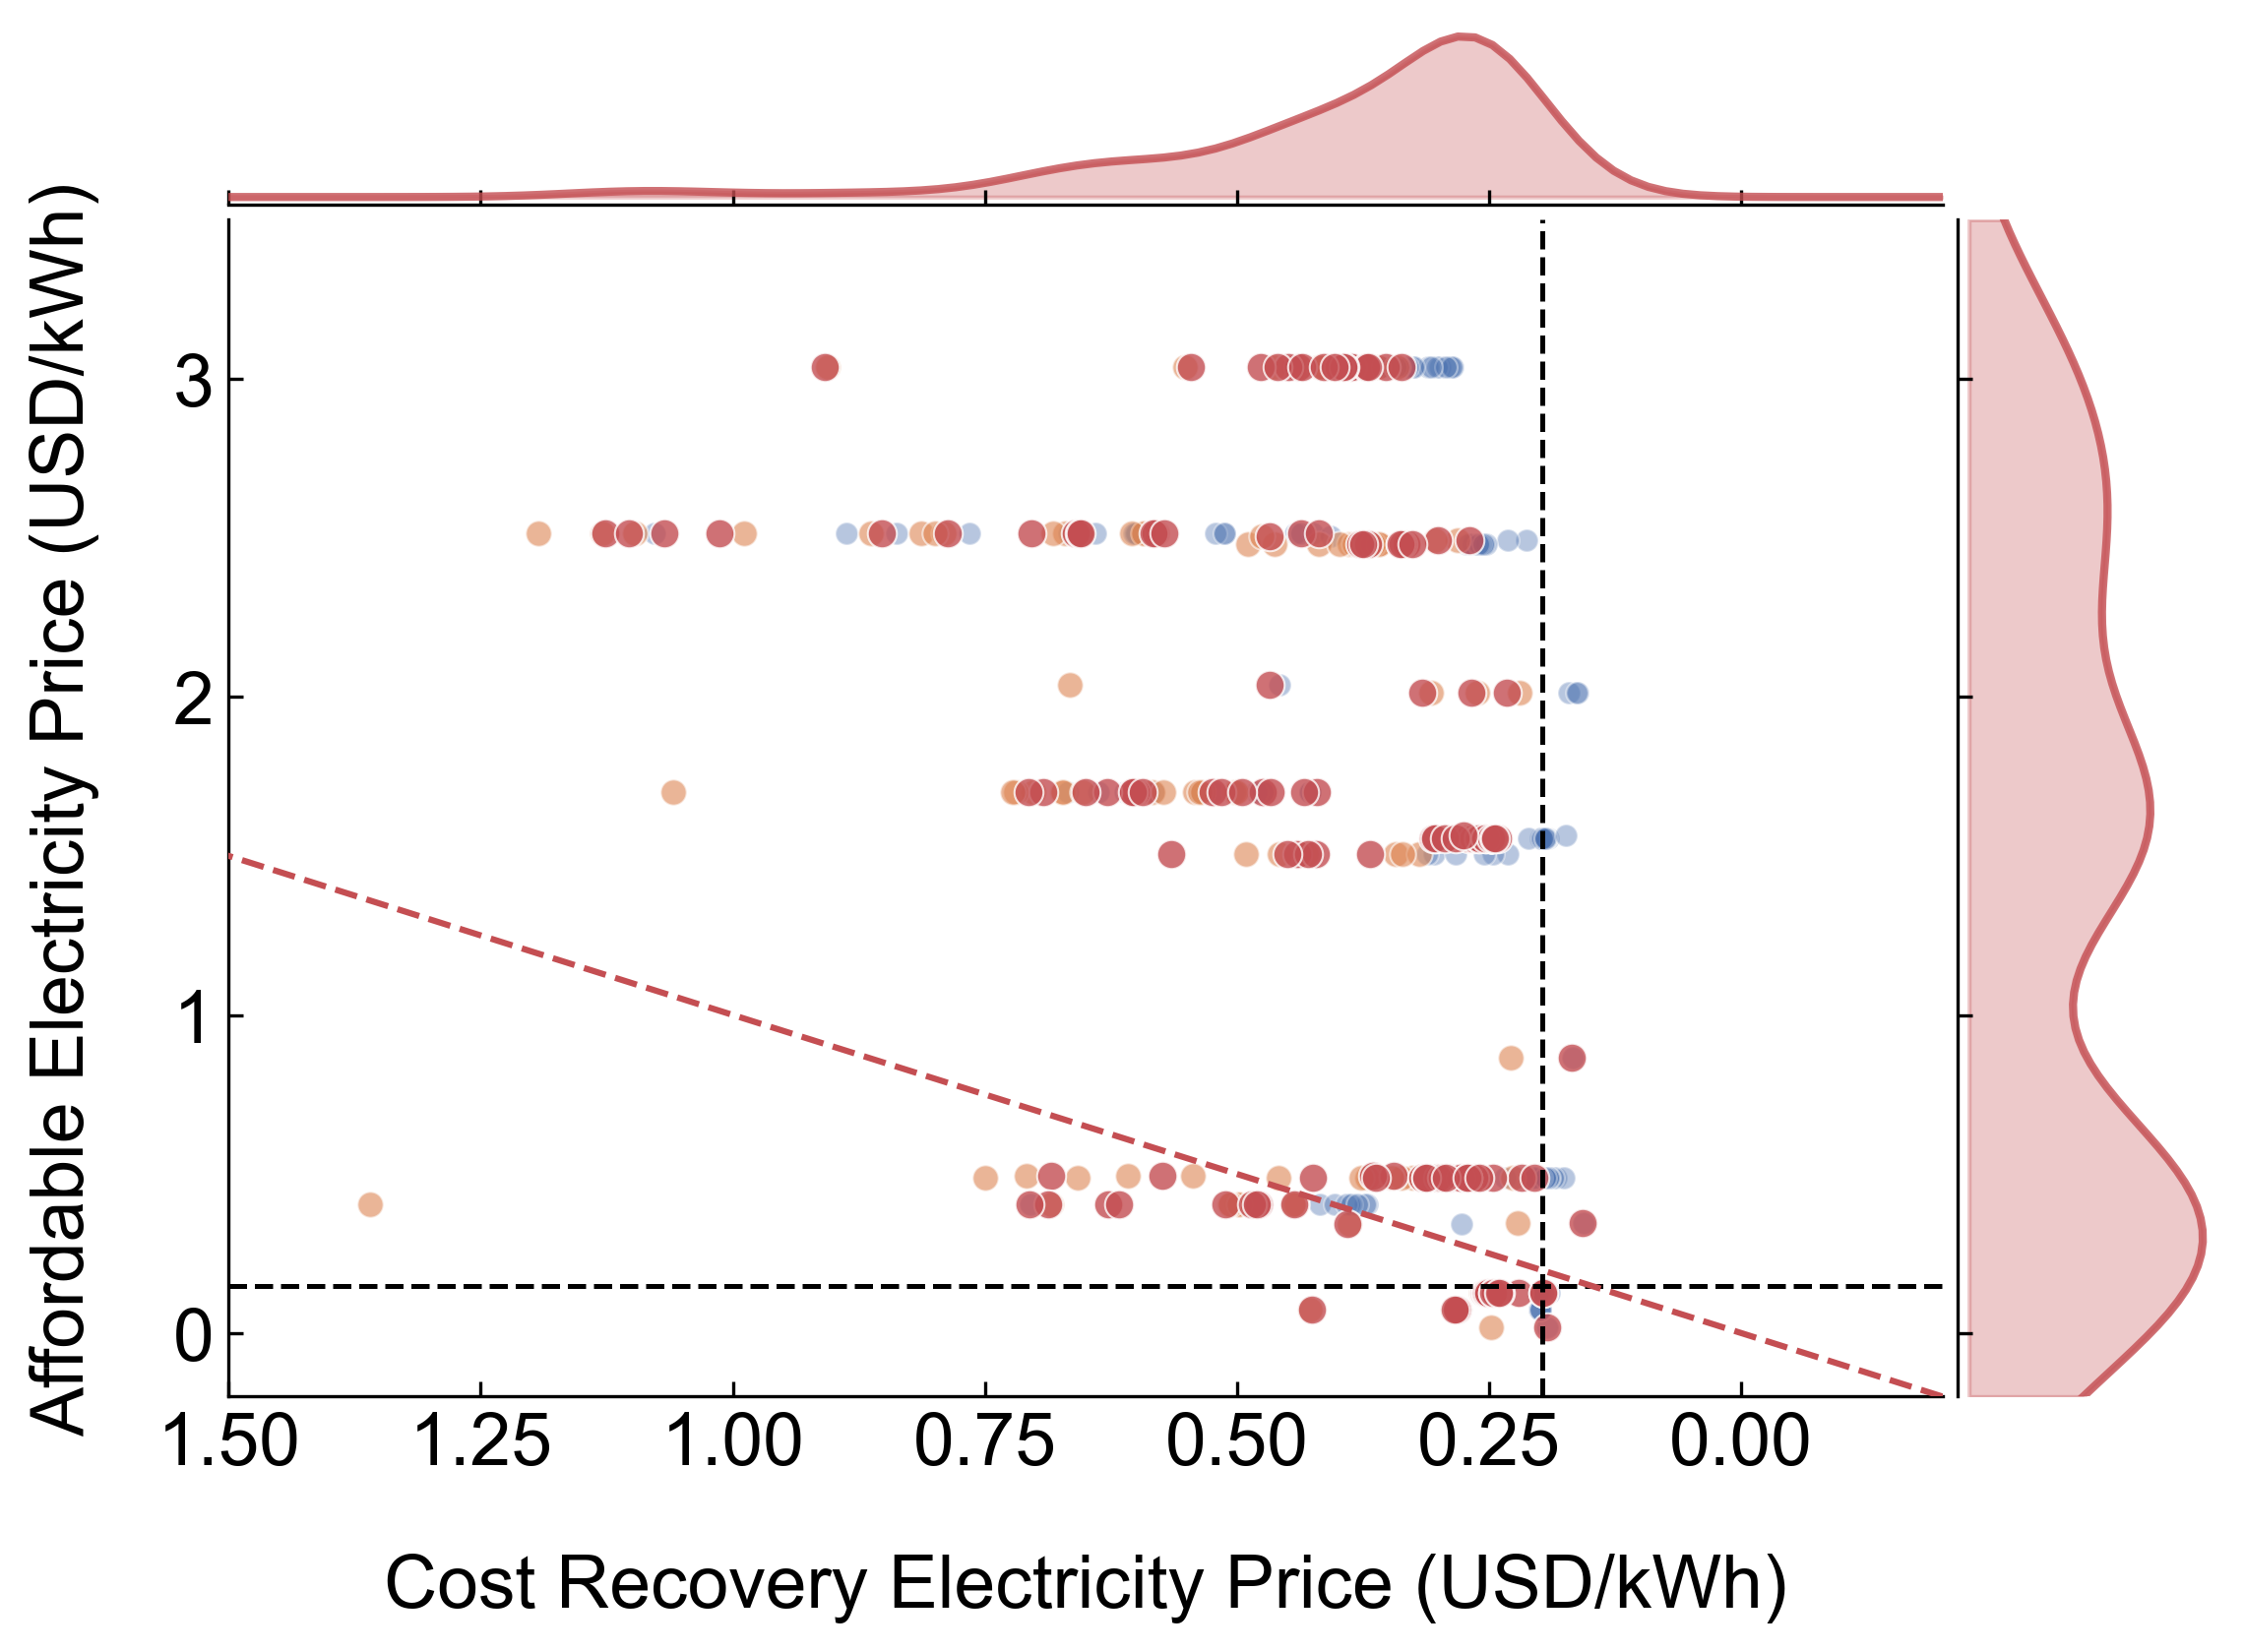


--- 统计分析结果 (仅针对显著变化的岛屿) ---
象限含义:
  Q1: Low Cost, High Affordable (最理想)
  Q2: High Cost, High Affordable
  Q3: High Cost, Low Affordable (最差)
  Q4: Low Cost, Low Affordable
  Non-feasible: 成本超过可负担能力
                Q1   Q2  Q3  Q4  Non-feasible
Scenario                                     
Ideal           28  108  14  21            37
Baseline         0  136  35   0            50
Climate Stress   2  134  32   3            47
--------------------------------------------------


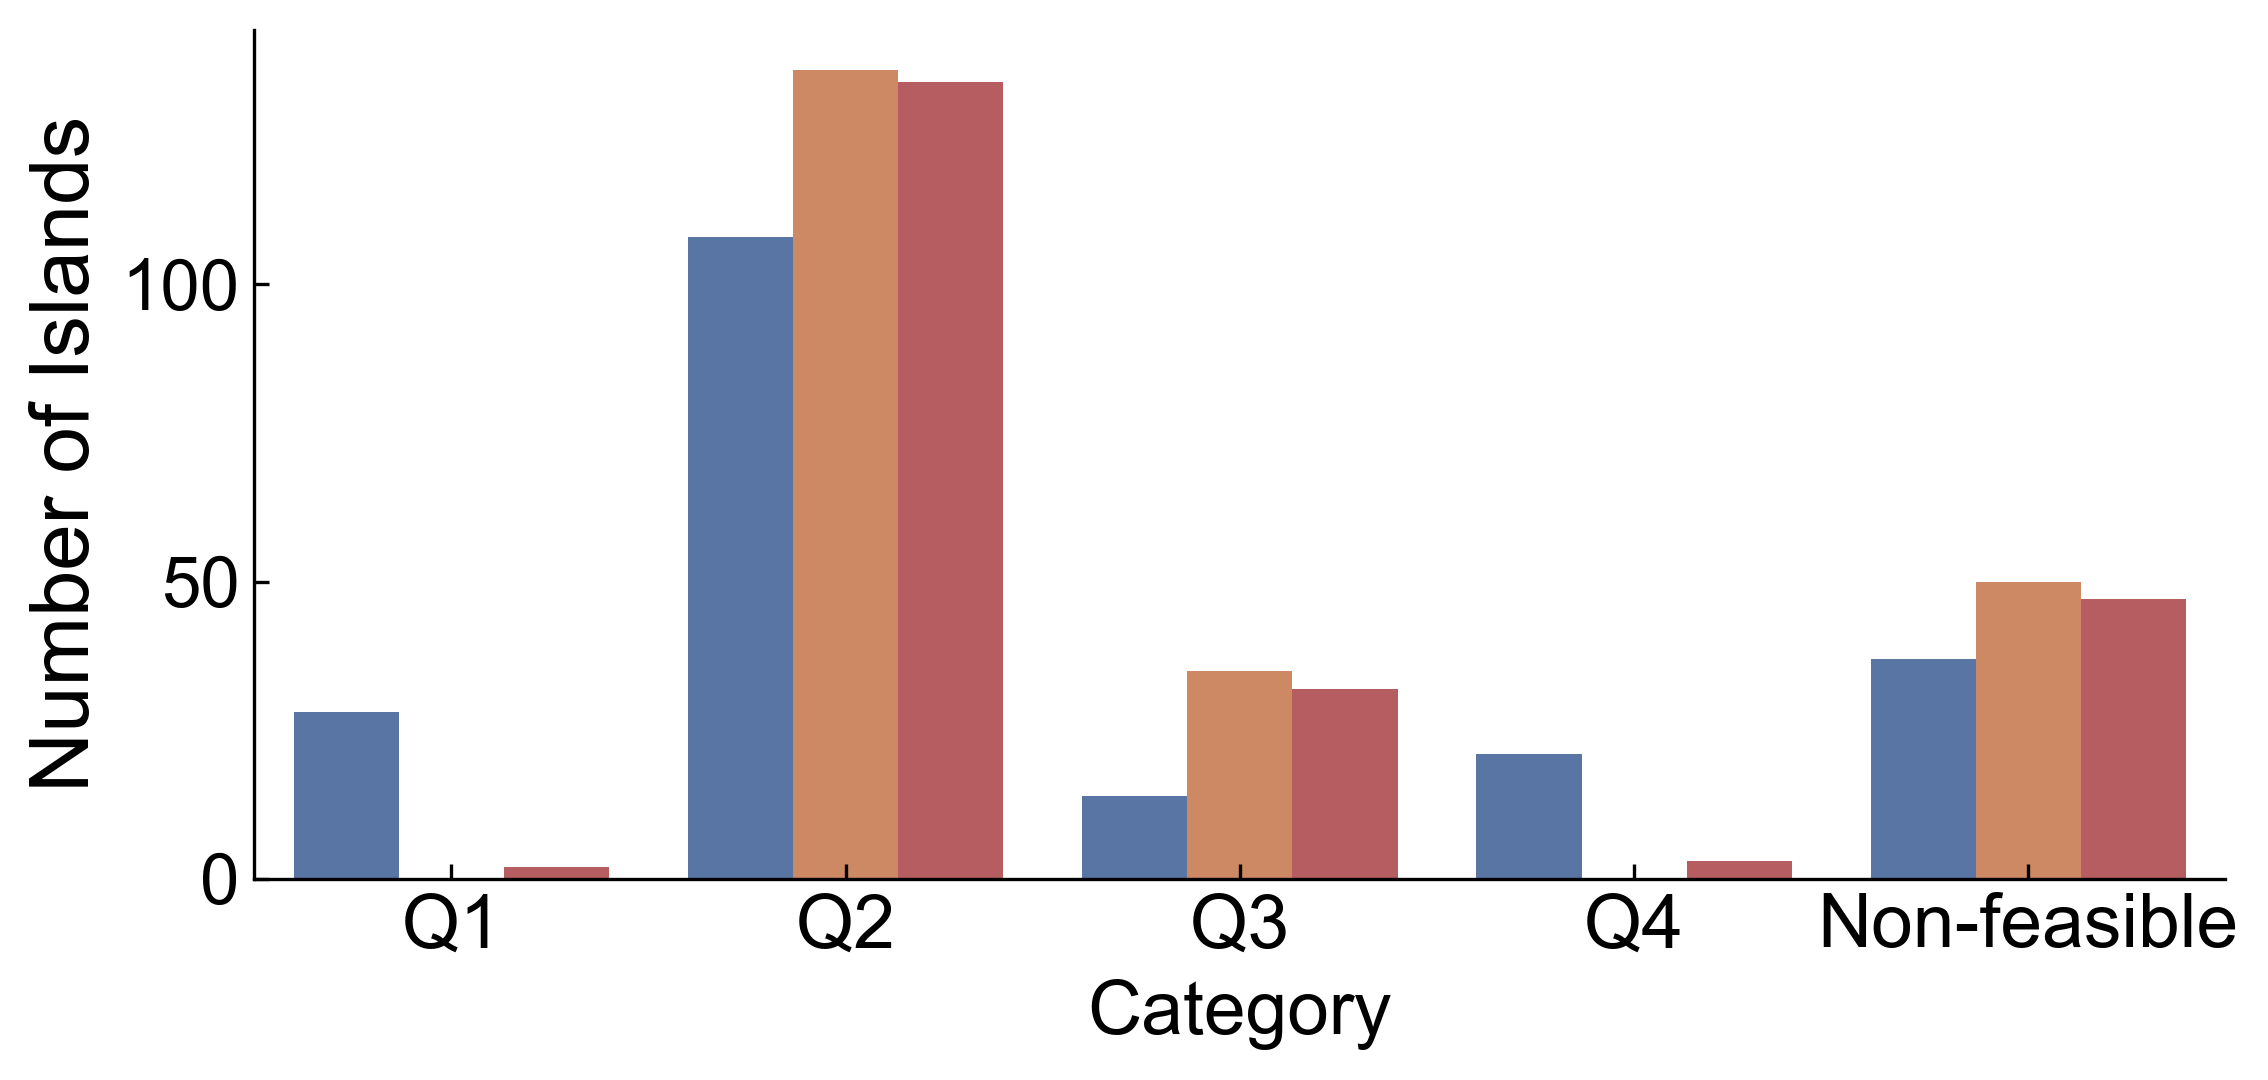

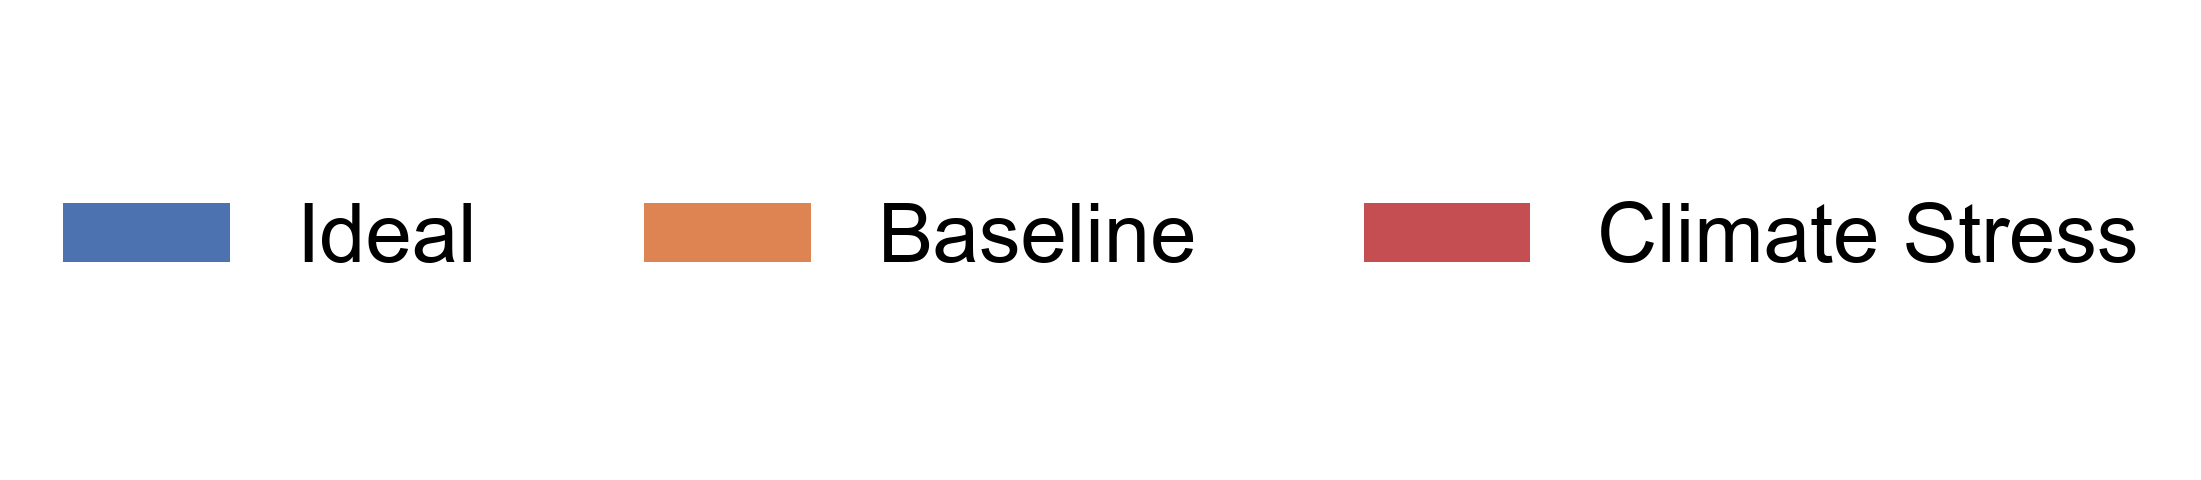

In [11]:
# --- Nature 风格图表设置 ---
# 在绘图前全局设置字体、字号等参数
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 20,  # 基础字号可以稍小，具体元素再调整
    'axes.labelsize': 18,
    'axes.titlesize': 16,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'figure.dpi': 300,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.direction': 'in', # 刻度线朝内
    'ytick.direction': 'in', # 刻度线朝内
})


# --- NEW: 新增的统计分析与绘图函数 ---
def analyze_and_plot_statistics(df_analysis, scenario_config, median_breakeven, median_affordable):
    """
    对数据进行象限和可负担性分析，并绘制条形图。
    使用统一的output_0中位数基准进行所有情景的分类。
    """
    results = []

    # 1. 遍历每个情景进行统计
    for scenario_name, config in scenario_config.items():
        scenario_df = df_analysis[df_analysis['scenario'] == scenario_name].copy()
        if scenario_df.empty:
            continue

        # 定义象限条件 - 统一使用output_0的中位数基准
        is_viable = (scenario_df['tariff_breakeven'] <= median_breakeven) & (scenario_df['tariff_affordable'] >= median_affordable)  # 使用output_0中位数基准
        is_marginal = (scenario_df['tariff_breakeven'] >= median_breakeven) & (scenario_df['tariff_affordable'] >= median_affordable)  # 使用output_0中位数基准
        is_limited = (scenario_df['tariff_breakeven'] <= median_breakeven) & (scenario_df['tariff_affordable'] <= median_affordable)  # 使用output_0中位数基准
        is_challenging = (scenario_df['tariff_breakeven'] >= median_breakeven) & (scenario_df['tariff_affordable'] <= median_affordable)  # 使用output_0中位数基准
        is_unaffordable = scenario_df['tariff_breakeven'] >= scenario_df['tariff_affordable']  # 不可行判断保持不变
        
        # 统计数量 - 使用简化的象限标签，正确映射到象限定义
        counts = {
            'Scenario': config['label'],
            'Q1': is_viable.sum(),          # Q1: Low Cost, High Affordable (最理想)
            'Q2': is_marginal.sum(),        # Q2: High Cost, High Affordable
            'Q3': is_challenging.sum(),     # Q3: High Cost, Low Affordable (最差)
            'Q4': is_limited.sum(),         # Q4: Low Cost, Low Affordable
            'Non-feasible': is_unaffordable.sum()  # 不可行：成本超过可负担能力
        }
        results.append(counts)
        
    if not results:
        print("没有可供分析的数据。")
        return
        
    # 2. 创建并打印统计结果的DataFrame
    stats_df = pd.DataFrame(results).set_index('Scenario')
    print("\n--- 统计分析结果 (仅针对显著变化的岛屿) ---")
    print("象限含义:")
    print("  Q1: Low Cost, High Affordable (最理想)")
    print("  Q2: High Cost, High Affordable")
    print("  Q3: High Cost, Low Affordable (最差)")
    print("  Q4: Low Cost, Low Affordable")
    print("  Non-feasible: 成本超过可负担能力")
    print(stats_df)
    print("-" * 50)
    
    # 3. 准备绘图数据
    stats_df_melted = stats_df.reset_index().melt(
        id_vars='Scenario',
        var_name='Category',
        value_name='Number of Islands'
    )
    
    # 提取颜色用于绘图
    palette = {config['label']: config['color'] for config in scenario_config.values()}
    
    # 定义nature系列的颜色调色板（5种颜色）
    nature_colors = ['#2E8B57', '#FF8C00', '#4682B4', '#DC143C', '#8B4513']  # 森林绿、橙、钢蓝、深红、棕色
    
    # 4. 创建竖向条形图 - 恢复为vertical
    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)  # 调整尺寸适应竖向布局
    
    # 使用seaborn绘制竖向条形图 - 恢复原始x和y参数
    bars = sns.barplot(
        data=stats_df_melted,
        x='Category',  # 恢复为x轴
        y='Number of Islands',  # 恢复为y轴
        hue='Scenario',
        palette=palette,
        ax=ax,
        # orient='h',  # 注释掉横向方向参数
        legend=False,  # 不在主图中显示图例
        order=['Q1', 'Q2', 'Q3', 'Q4', 'Non-feasible']  # 明确指定显示顺序
    )
    
    # # 4. 创建横向条形图 - 修改为horizontal（注释掉）
    # fig, ax = plt.subplots(figsize=(5, 8), dpi=300)  # 调整尺寸适应横向布局
    
    # # 使用seaborn绘制横向条形图 - 交换x和y参数
    # bars = sns.barplot(
    #     data=stats_df_melted,
    #     y='Category',  # 原x轴变为y轴
    #     x='Number of Islands',  # 原y轴变为x轴
    #     hue='Scenario',
    #     palette=palette,
    #     ax=ax,
    #     orient='h',  # 指定横向方向
    #     legend=False  # 不在主图中显示图例
    # )
    
    # 美化图表 - 恢复为竖向标签
    # ax.set_title(f'Statistical Distribution of Islands by Category ({scenario_name})', fontsize=14, pad=15)
    # ax.set_xlabel('Quadrant Classification', fontsize=20)  # 更新x轴标签为象限分类
    ax.set_ylabel('Number of Islands', fontsize=20)  # 恢复为y轴标签
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', labelsize=17)
    
    # x轴标签会自动按照order参数显示Q1-Q2-Q3-Q4-Non-feasible的顺序
    ax.tick_params(axis='x', labelsize=18)  # 设置x轴标签大小
    
    # 在条形图上添加数字标签（竖向版本）
    # for p in ax.patches:
    #     height = p.get_height()  # 竖向柱状图获取高度
    #     if height > 0:  # 只在非零值上添加标签
    #         ax.annotate(f'{int(height)}', 
    #                     (p.get_x() + p.get_width() / 2., height),  # 恢复位置
    #                     ha='center', va='bottom',  # 恢复对齐方式
    #                     xytext=(0, 3),  # 恢复偏移
    #                     textcoords='offset points',
    #                     fontsize=16)

    fig.tight_layout()
    plt.show()
    
    # 5. 单独创建图例，无边框
    fig_legend, ax_legend = plt.subplots(figsize=(8, 2), dpi=300)  # 图例单独的图形
    ax_legend.axis('off')  # 隐藏坐标轴
    
    # 创建图例元素
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=config['color'], 
                                    label=config['label']) 
                      for config in scenario_config.values()]
    
    # 创建无边框图例
    legend = ax_legend.legend(handles=legend_elements, 
                             loc='center',  # 居中显示
                             ncol=len(scenario_config),  # 水平排列
                             fontsize=20,  # 字体大小
                             frameon=False)  # 无边框
    
    # 调整图例样式
    for text in legend.get_texts():
        text.set_fontweight('normal')  # 字体粗细
    
    fig_legend.tight_layout()
    plt.show()

# --- 核心绘图函数（修改为plot_feasibility_quadrant样式） ---
def plot_three_scenario_changes(df, base_scenario, final_scenario, zoom_config, scenario_config, change_threshold=0.1):
    """
    筛选出在首尾情景间有显著变化的岛屿，绘制它们的位置，并进行统计分析。
    使用plot_feasibility_quadrant的样式，并为红色点添加xy轴密度图。
    """
    if df.empty:
        print("数据为空，跳过绘图。")
        return

    # 1. 筛选出用于计算变化的起始和最终情景数据
    df_base = df[df['scenario'] == base_scenario]
    df_final = df[df['scenario'] == final_scenario]

    if df_base.empty or df_final.empty:
        print(f"缺少 {base_scenario} 或 {final_scenario} 的数据，无法计算变化。")
        return

    # 2. 计算并筛选出有显著变化的岛屿
    change_data = calculate_position_change(df_base, df_final)
    significant_changes = change_data[change_data['position_change'] > change_threshold]

    if significant_changes.empty:
        print(f"在阈值 {change_threshold} 下未发现显著变化的岛屿。")
        return

    significant_island_ids = significant_changes['island_id'].unique()
    print(f"发现 {len(significant_island_ids)} 个有显著变化的岛屿（在 {base_scenario} 和 {final_scenario} 之间）。")

    # 3. 从原始数据中筛选出这些岛屿在 *所有情景* 中的数据
    df_plot = df[df['island_id'].isin(significant_island_ids)].copy()

    # === 创建带边际密度图的主图 ===
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # 创建主图
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)  # 主图尺寸

    # 创建divider用于添加边际图
    divider = make_axes_locatable(ax)

    # 添加上方（x轴密度）和右侧（y轴密度）子图
    ax_top = divider.append_axes("top", size="15%", pad=0.05, sharex=ax)  # 上方密度图高度为主图的20%
    ax_right = divider.append_axes("right", size="15%", pad=0.05, sharey=ax)  # 右侧密度图宽度为主图的20%

    # 隐藏边际图的刻度标签
    plt.setp(ax_top.get_xticklabels(), visible=False)  # 隐藏上方密度图的x轴标签
    plt.setp(ax_right.get_yticklabels(), visible=False)  # 隐藏右侧密度图的y轴标签

    # --- 绘制主散点图 ---
    for scenario_name, config in scenario_config.items():
        scenario_df = df_plot[df_plot['scenario'] == scenario_name]
        if not scenario_df.empty:
            ax.scatter(scenario_df['tariff_breakeven'], scenario_df['tariff_affordable'],
                       color=config['color'],  # 情景颜色
                       label=config['label'],  # 情景标签
                       alpha=config['alpha'], s=config['size'], edgecolors='white', linewidth=0.5, zorder=3)  # 透明度、大小、边框

    # --- 设置坐标轴和标题 ---
    ax.set_xlabel('Cost Recovery Electricity Price (USD/kWh)', labelpad=18)  # x轴标签和间距
    ax.set_ylabel('Affordable Electricity Price (USD/kWh)', labelpad=18)  # y轴标签和间距

    # --- 翻转横轴，让低成本在右边 ---
    ax.invert_xaxis()  # 横轴翻转

    # --- "Despine" - 移除顶部和右侧轴线 ---
    ax.spines[['right', 'top']].set_visible(False)

    # --- 添加辅助线 ---
    median_breakeven = df_base['tariff_breakeven'].median()  # 基础情景的中位数作为分界线
    median_affordable = df_base['tariff_affordable'].median()  # 基础情景的中位数作为分界线
    ax.axvline(x=median_breakeven, color='black', linestyle='--', linewidth=1.2, zorder=3)  # 垂直中位线
    ax.axhline(y=median_affordable, color='black', linestyle='--', linewidth=1.2, zorder=3)  # 水平中位线

    ax.set_xlim(1.5, -0.2)  # x轴范围
    ax.set_ylim(-0.2, 3.5)  # y轴范围

    # 45度线（盈亏平衡线）
    lim_min = min(ax.get_xlim()[0], ax.get_ylim()[0])  # 坐标轴最小值
    lim_max = max(ax.get_xlim()[1], ax.get_ylim()[1])  # 坐标轴最大值
    ax.plot([lim_min, lim_max], [lim_min, lim_max], color='#C44E52', linestyle='--',
              alpha=1, linewidth=1.5, label='Break-even line', zorder=3)  # 45度线样式
    ax.grid(False)  # 关闭网格

    # --- 添加密度图：针对红色点（Climate Stress scenario）---
    # 获取红色点数据（Climate Stress scenario，即'output_2050'）
    red_scenario_data = df_plot[df_plot['scenario'] == 'output_2050']

    if not red_scenario_data.empty and len(red_scenario_data) > 3:  # 确保有足够数据进行密度估计
        try:
            # x轴（tariff_breakeven）密度图
            x_data = red_scenario_data['tariff_breakeven'].values  # 提取x轴数据
            if len(x_data) > 1:
                kde_x = stats.gaussian_kde(x_data)  # 核密度估计
                x_range = np.linspace(ax.get_xlim()[1], ax.get_xlim()[0], 100)  # x轴密度估计范围（注意翻转）
                density_x = kde_x(x_range)  # 计算密度值

                # 绘制上方密度图
                ax_top.plot(x_range, density_x, color='#C44E52', linewidth=2, alpha=0.8)  # 密度曲线，红色，线宽2
                ax_top.fill_between(x_range, density_x, alpha=0.3, color='#C44E52')  # 填充区域，红色，透明度0.3
                ax_top.set_xlim(ax.get_xlim())  # 与主图x轴范围保持一致
                ax_top.spines[['right', 'top', 'left']].set_visible(False)  # 隐藏边框
                ax_top.set_yticks([])  # 隐藏y轴刻度
                ax_top.set_facecolor('none')  # 背景透明

            # y轴（tariff_affordable）密度图
            y_data = red_scenario_data['tariff_affordable'].values  # 提取y轴数据
            if len(y_data) > 1:
                kde_y = stats.gaussian_kde(y_data)  # 核密度估计
                y_range = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100)  # y轴密度估计范围
                density_y = kde_y(y_range)  # 计算密度值

                # 绘制右侧密度图
                ax_right.plot(density_y, y_range, color='#C44E52', linewidth=2, alpha=0.8)  # 密度曲线，红色，线宽2
                ax_right.fill_betweenx(y_range, density_y, alpha=0.3, color='#C44E52')  # 填充区域，红色，透明度0.3
                ax_right.set_ylim(ax.get_ylim())  # 与主图y轴范围保持一致
                ax_right.spines[['right', 'top', 'bottom']].set_visible(False)  # 隐藏边框
                ax_right.set_xticks([])  # 隐藏x轴刻度
                ax_right.set_facecolor('none')  # 背景透明

        except Exception as e:
            print(f"密度图绘制失败: {e}")  # 错误处理

    # --- 创建放大视图 ---
    zoom_data = df_plot[
        (df_plot['tariff_breakeven'].between(zoom_config['x_min'], zoom_config['x_max'])) &
        (df_plot['tariff_affordable'].between(zoom_config['y_min'], zoom_config['y_max']))
    ]
    
    # if not zoom_data.empty:
    #     # 创建主子图
    #     inset_ax = ax.inset_axes([0.08, 0.25, 0.5, 0.5])  # 使用相同的放大视图位置和大小
        
    #     # 创建divider来添加边际图
    #     # divider = make_axes_locatable(inset_ax)
        
    #     # # 添加上方和右方的边际图
    #     # ax_top = divider.append_axes("top", size="25%", pad=0.05, sharex=inset_ax)
    #     # ax_right = divider.append_axes("right", size="25%", pad=0.05, sharey=inset_ax)
        
    #     # 隐藏边际图的刻度标签
    #     # plt.setp(ax_top.get_xticklabels(), visible=False)
    #     # plt.setp(ax_right.get_yticklabels(), visible=False)
        
    #     # 绘制主散点图
    #     for scenario_name, config in scenario_config.items():
    #         zoom_scenario_data = zoom_data[zoom_data['scenario'] == scenario_name]
    #         if not zoom_scenario_data.empty:
    #             inset_ax.scatter(zoom_scenario_data['tariff_breakeven'], zoom_scenario_data['tariff_affordable'],
    #                              color=config['color'], alpha=config['alpha'], s=config['size'] + 10, 
    #                              edgecolors='white', linewidth=0.5)

    #     # 中位线
    #     inset_ax.axvline(x=median_breakeven, color='black', linestyle='--', linewidth=1.2, zorder=1)
    #     inset_ax.axhline(y=median_affordable, color='black', linestyle='--', linewidth=1.2, zorder=1)
        
    #     # 在小图中添加 y=x 线
    #     inset_lim_min = max(zoom_config['x_min'], zoom_config['y_min'])
    #     inset_lim_max = min(zoom_config['x_max'], zoom_config['y_max'])
    #     inset_ax.plot([inset_lim_min, inset_lim_max], [inset_lim_min, inset_lim_max], 
    #                   color='#C44E52', linestyle='--', alpha=1, linewidth=1.5, zorder=1)
        
    #     # 设置放大视图范围和样式
    #     inset_ax.set_xlim(zoom_config['x_min'], zoom_config['x_max'])
    #     inset_ax.set_ylim(zoom_config['y_min'], zoom_config['y_max'])
    #     inset_ax.tick_params(labelsize=12)
    #     inset_ax.grid(False)
        
    #     # 翻转放大子图的横轴
    #     inset_ax.invert_xaxis()
        
    #     # --- 添加密度曲线 ---
    #     # 上方密度图 (x轴密度)
    #     # x_data = zoom_data['tariff_breakeven']
    #     # if len(x_data) > 1:
    #     #     # 使用核密度估计
    #     #     kde_x = stats.gaussian_kde(x_data)
    #     #     x_range = np.linspace(zoom_config['x_min'], zoom_config['x_max'], 100)
    #     #     density_x = kde_x(x_range)
    #     #     ax_top.plot(x_range, density_x, color='#2E8B57', linewidth=2)
    #     #     ax_top.fill_between(x_range, density_x, alpha=0.3, color='#2E8B57')
    #     #     ax_top.set_xlim(zoom_config['x_min'], zoom_config['x_max'])
    #     #     # 让上方密度图背景透明
    #     #     ax_top.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    #     #     ax_top.set_yticks([])
    #     #     ax_top.set_facecolor('none')  # 设置背景透明
    #     #     # 翻转上方密度图的横轴
    #     #     ax_top.invert_xaxis()
        
    #     # # 右侧密度图 (y轴密度)
    #     # y_data = zoom_data['tariff_affordable']
    #     # if len(y_data) > 1:
    #     #     kde_y = stats.gaussian_kde(y_data)
    #     #     y_range = np.linspace(zoom_config['y_min'], zoom_config['y_max'], 100)
    #     #     density_y = kde_y(y_range)
    #     #     ax_right.plot(density_y, y_range, color='#FF8C00', linewidth=2)
    #     #     ax_right.fill_betweenx(y_range, density_y, alpha=0.3, color='#FF8C00')
    #     #     ax_right.set_ylim(zoom_config['y_min'], zoom_config['y_max'])
    #     #     # 让右侧密度图背背景透明
    #     #     ax_right.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    #     #     ax_right.set_xticks([])
    #     #     ax_right.set_facecolor('none')  # 设置背景透明
        
    #     inset_ax.text(0.03, 0.95, 'Zoomed View', transform=inset_ax.transAxes, 
    #                   ha='left', va='top', fontsize=12, weight='bold')

    #     # 添加连接线
    #     mark_inset(ax, inset_ax, loc1=1, loc2=4, fc="none", ec="0.5")

    # --- 图例和显示 ---
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))  # 不显示图例，将在最后单独生成
    
    # --- 调整并保存/显示 ---
    fig.tight_layout()
    plt.show()

    # --- MODIFIED: 调用新的分析函数 ---
    analyze_and_plot_statistics(df_plot, scenario_config, median_breakeven, median_affordable)


# ===== 主程序 =====
if __name__ == '__main__':
    # 检查ipcc_region列是否存在
    if 'ipcc_region' not in df.columns:
        print("错误：ipcc_region列不存在，无法执行分析")
    else:
        print(f"ipcc_region列已存在，开始分析...")
        
        # --- 2. 绘图配置 ---
        ZOOM_BOX = {
            'x_min': 0.08, 'x_max': 0.9,  # 使用与plot_feasibility_quadrant相同的放大视图配置
            'y_min': -0.12, 'y_max': 1
        }

        SCENARIO_CONFIG = {
            'output_0': {
                'label': 'Ideal',
                'color': '#4C72B0',  # Blue
                'alpha': 0.4,  # 调整透明度与plot_feasibility_quadrant一致
                'size': 30,  # 调整点大小与plot_feasibility_quadrant一致
                'zorder': 2
            },
            'output_2020': {
                'label': 'Baseline',
                'color': '#DD8452',  # Orange
                'alpha': 0.6,
                'size': 40,
                'zorder': 3
            },
            'output_2050': {
                'label': 'Climate Stress',
                'color': '#C44E52',  # Red
                'alpha': 0.8,
                'size': 50,
                'zorder': 4
            }
        }

        # --- 3. 筛选并绘图 ---
        scenarios_to_plot = list(SCENARIO_CONFIG.keys())
        df_filtered = df[df['scenario'].isin(scenarios_to_plot)].copy()

        print(f"\n--- 正在对比三个情景，但只显示在 'output_0' 和 'output_2020' 之间有显著变化的岛屿 ---")
        
        if not df_filtered.empty:
            plot_three_scenario_changes(
                df=df_filtered,
                base_scenario='output_0',
                final_scenario='output_2020',
                zoom_config=ZOOM_BOX,
                scenario_config=SCENARIO_CONFIG,
                change_threshold=0.05 
            )
        else:
            print("没有足够的数据用于绘图。")

开始创建点密度世界地图...
发现 171 个有显著变化的岛屿
显著变化岛屿的IPCC区域分布:
ipcc_region
NEU    37
SEA    29
EAS    27
SWS    22
NWN    16
WNA     8
RFE     7
NPO     6
SSA     5
BOB     3
ENA     3
SAU     2
NZ      2
SPO     1
GIC     1
MDG     1
NAU     1
Name: count, dtype: int64
点大小范围: 50.0 - 500.0
变化量范围: 0.050 - 0.655


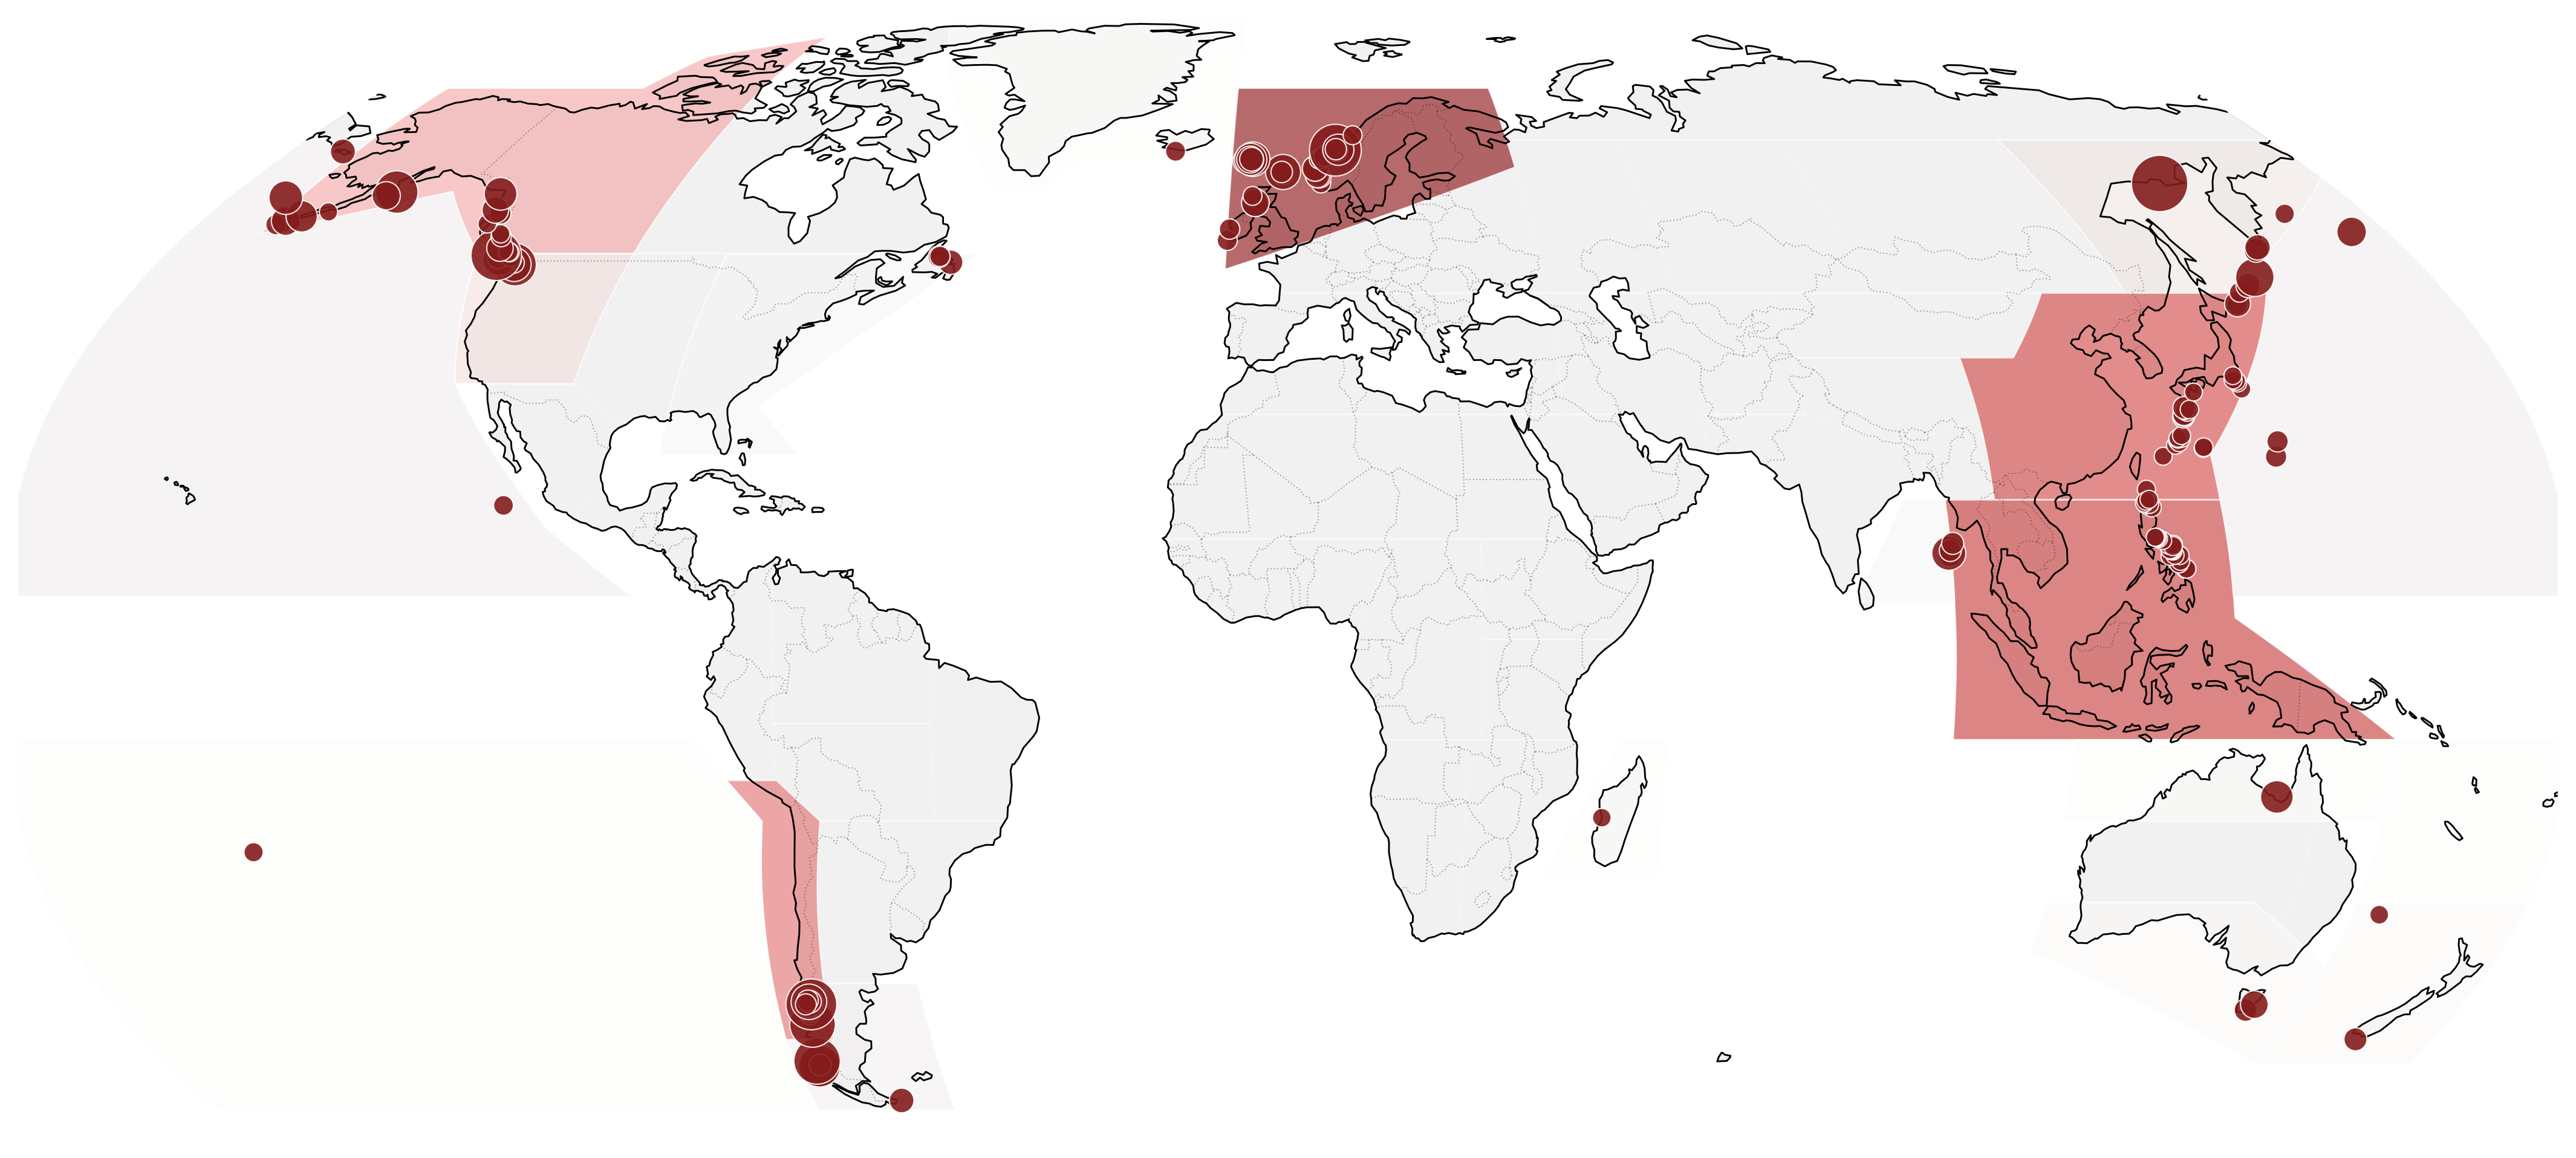


=== 世界地图统计摘要 ===
总共标记了 171 个有显著变化的岛屿
涉及 17 个IPCC区域
变化最多的区域: NEU (37 个岛屿)


In [8]:
# 7. --- 基于有明显变化岛屿的点密度世界地图 ---

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter

print("开始创建点密度世界地图...")

# 计算岛屿变化数据
df_base = df[(df['scenario'] == 'output_0')].copy()
df_compare = df[(df['scenario'] == 'output_2020')].copy()

# 使用现有的calculate_position_change函数
change_data = calculate_position_change(df_base, df_compare)
significant_changes = change_data[change_data['position_change'] > 0.05]  # 显著变化阈值

print(f"发现 {len(significant_changes)} 个有显著变化的岛屿")

if len(significant_changes) > 0:
    # 获取有显著变化岛屿的位置信息
    significant_islands = df_base[df_base['island_id'].isin(significant_changes['island_id'])].copy()
    
    # 将变化量信息合并到岛屿数据中
    significant_islands = significant_islands.merge(
        significant_changes[['island_id', 'position_change']], 
        on='island_id', how='left'
    )
    
    print(f"显著变化岛屿的IPCC区域分布:")
    region_counts = significant_islands['ipcc_region'].value_counts()
    print(region_counts)
    
    # 读取IPCC区域地理数据
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")

    # 创建世界地图
    fig = plt.figure(figsize=(14, 8.5), dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    # 设置背景和地图特征
    ax.set_facecolor("#FFFFFF")
    ax.add_feature(cfeature.LAND, color="#CECECE", alpha=0.4)
    ax.add_feature(cfeature.OCEAN, color="#FFFFFF", alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, alpha=0.3)
    
    # 计算每个IPCC区域的显著变化岛屿数量
    if not region_counts.empty:
        # 创建红色渐变色彩映射（白色到深红色）
        vmin, vmax = region_counts.min(), region_counts.max()
        norm = Normalize(vmin=0, vmax=vmax)  # 从0开始，确保没有岛屿的区域为白色
        
        # 创建自定义红色渐变色彩映射
        colors = ['#FFFFFF', '#F1EEED', '#FCCDC9', '#EE9D9F', '#DE6A69', '#C84747', '#982B2D']  # 白色到深红色渐变
        red_colormap = LinearSegmentedColormap.from_list('red_gradient', colors, N=256)
        
        # 为每个IPCC区域着色
        for _, region_row in ipcc_regions.iterrows():
            region_code = region_row['Acronym']
            
            if region_code in region_counts.index:
                # 该区域有显著变化的岛屿
                island_count = region_counts[region_code]
                color = red_colormap(norm(island_count))
                alpha = 0.7  # 有数据的区域更不透明
                
                # 绘制填充的区域
                ax.add_geometries([region_row['geometry']], crs=ccrs.PlateCarree(),
                                  facecolor=color,
                                  edgecolor='white',
                                  linewidth=0.5,
                                  alpha=alpha,
                                  zorder=1)
            else:
                # 该区域没有显著变化的岛屿，保持浅色
                ax.add_geometries([region_row['geometry']], crs=ccrs.PlateCarree(),
                                  facecolor='white',
                                  edgecolor="#FFFFFF",
                                  linewidth=0.3,
                                  alpha=0.3,
                                  zorder=1)
    
    # 在地图上标注显著变化的岛屿点 - 根据变化量调整点的大小
    if not significant_islands.empty:
        # 计算点大小：根据position_change缩放
        change_values = significant_islands['position_change'].values
        min_change = change_values.min()  # 最小变化量
        max_change = change_values.max()  # 最大变化量
        
        # 设置点大小范围
        min_size = 50   # 最小点大小
        max_size = 500  # 最大点大小
        
        # 线性缩放点大小：变化量越大，点越大
        if max_change > min_change:
            normalized_changes = (change_values - min_change) / (max_change - min_change)  # 归一化到0-1
            point_sizes = min_size + normalized_changes * (max_size - min_size)  # 缩放到指定范围
        else:
            # 如果所有变化量相同，使用中等大小
            point_sizes = np.full(len(change_values), (min_size + max_size) / 2)
        
        # 使用深红色圆点标记有显著变化的岛屿
        scatter = ax.scatter(significant_islands['lon'], significant_islands['lat'],
                   transform=ccrs.PlateCarree(),  # 坐标转换
                   c="#841C1C",  # 深红色点
                   s=point_sizes,  # 根据变化量调整点大小
                   alpha=0.9,  # 透明度参数，让点更加明显
                   edgecolors='white',  # 白色边框
                   linewidth=0.5,  # 边框宽度参数
                   zorder=3)  # 确保点显示在最上层
        
        print(f"点大小范围: {point_sizes.min():.1f} - {point_sizes.max():.1f}")
        print(f"变化量范围: {min_change:.3f} - {max_change:.3f}")
    
    # 设置视图范围，排除南极洲
    ax.set_extent([-180, 180, -60, 85], crs=ccrs.PlateCarree())
    
    # 添加颜色条图例
    # if not region_counts.empty:
    #     # 创建颜色条
    #     sm = cm.ScalarMappable(norm=norm, cmap=red_colormap)
    #     sm.set_array([])
        
    #     # 在右侧添加颜色条
    #     cbar = plt.colorbar(sm, ax=ax, orientation='vertical', 
    #                        pad=0.02, shrink=0.6, aspect=20)
    #     cbar.set_label('Number of Islands with Significant Changes', 
    #                    rotation=270, labelpad=20, fontsize=20)  # 颜色条标签
    #     cbar.ax.tick_params(labelsize=10)  # 颜色条刻度标签大小参数
    
    # 添加标题
    # ax.set_title('Global Distribution of Islands with Significant Tariff Changes\n(Baseline vs Climate Stress Scenarios)', 
    #              fontsize=14, fontweight='bold', pad=20)
    
    # 去除坐标轴刻度
    ax.set_xticks([])
    ax.set_yticks([])
    # 去除边框
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 去除所有边距，只显示图像内容
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.axis('off')
    plt.show()
    
    # 打印统计摘要
    print(f"\n=== 世界地图统计摘要 ===")
    print(f"总共标记了 {len(significant_islands)} 个有显著变化的岛屿")
    print(f"涉及 {len(region_counts)} 个IPCC区域")
    print(f"变化最多的区域: {region_counts.index[0]} ({region_counts.iloc[0]} 个岛屿)")
    
else:
    print("没有发现显著变化的岛屿，无法创建地图可视化")